# Billiard Propagation and Plotting Routines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.widgets import Slider
from boundary import *
import rootfinding as rf
custom_rf = {'tol': 2E-12, 'maxiter': 50,
             'rootfind_open': rf.newton,
             'rootfind_bracketing': rf.bisect,
             'param_rootfind': 'bracketing'}
np.set_printoptions(precision=7, suppress=True)
figscale = 0.75

I'll propagate billiards using a generator-iterator ('billiard_propagator_gen') and save billiard state in a dictionary. The state dictionary will hold the propagator, the trajectory as an array of (x,y) coordinates, the boundary collision points as a list of boundary parameters (denoted 's'), a list of the tangential component of velocity ('v_tan') at each collision, and a reference to the boundary object.

In [2]:
def billiard_propagator_gen(r, v, bdy):
    s = bdy.linear_intersect_cart(r, v)
    if np.any(np.sign(bdy.coords_cart(s) - r) != np.sign(v)):
        # Then we found the intercept in the wrong direction! Try again.
        try:
            # the intersect_param method excludes passed root s if
            s = bdy.linear_intersect_param(s, v)
        except RuntimeError as e:
            print e
    while True:
        tangent = bdy.tangent_cart(s)
        v_tan = np.dot(v, tangent)
        yield s, v_tan
        v = 2 * v_tan * tangent - v
        try:
            s = bdy.linear_intersect_param(s, v)
        except RuntimeError as e:
            print e

def init_state(r, v, boundary):
    """Initialize state given i.c.'s, position r and velocity v, for
        the given boundary.
    """
    state = {'s_list': [],
             'v_tan_list': [],
             'trajectory': np.c_[r],
             'propagator': billiard_propagator_gen(r, v, boundary),
             'boundary': boundary}
    return state


def propagate(state, bounces):
    """Update state by a number 'bounces' of collisions.
    """
    new_s, new_v_tan = zip(*(state['propagator'].next()
                             for _ in xrange(int(bounces))))
    state['s_list'].extend(new_s)
    state['v_tan_list'].extend(new_v_tan)
    state['trajectory'] = np.c_[state['trajectory'],
                                state['boundary']\
                                .coords_cart(np.array(new_s))]

I'll be producing trajectory plots and Poincaré sections, and I want to be able to play with them, so I'll use functions to initialize and update plot data. This allows me to add sliders to relevant figures to control the number of collisions and the deviation from initial conditions of the displayed data.

In [3]:
def propagate_plots(fig, state, n, traj_line=None, poinc_ax=None,
                    clear_poinc_ax=True, **plot_kwargs):
    """Update plots to show 'n' collisions of given state.
    
    Optional: traj_line, the plotline of the trajectory to update;
              poinc_ax, the axis of the Poincare section to update.
    If the state does not know n collisions, first propagate it
     to the necessary number.
    """
    clr = clear_poinc_ax and poinc_ax is not None
    if clr: 
        for item in poinc_ax.collections: item.remove()
        del poinc_ax.collections[:]
    missing = n+1 - state['trajectory'].shape[1]
    if missing <= 0:
        if traj_line is not None:
            traj_line.set_xdata(state['trajectory'][0, 0:n+1])
            traj_line.set_ydata(state['trajectory'][1, 0:n+1])
        if poinc_ax is not None:
            poinc_ax.scatter(state['s_list'][0:n+1],
                             state['v_tan_list'][0:n+1],
                             **plot_kwargs)
    else:
        propagate(state, missing)   
        if traj_line is not None: 
            traj_line.set_xdata(state['trajectory'][0])
            traj_line.set_ydata(state['trajectory'][1])
        if poinc_ax is not None:
            poinc_ax.scatter(state['s_list'],
                             state['v_tan_list'],
                             **plot_kwargs)
    if clr:
        poinc_ax.set_ylim([-1, 1])
        poinc_ax.set_xlim([0, 2*np.pi])
    fig.canvas.draw()


def reset_plots(fig, r, v, boundary, n, traj_line=None,
                poinc_ax=None, **propagate_plots_kwargs):
    """Reinitialize data for given initial conditions.
    
    Optional: traj_line, the plotline of the trajectory to update;
              poinc_ax, the axis of the Poincare section to update.
    """
    state = init_state(r, v, boundary)
    propagate_plots(fig, state, n, traj_line, poinc_ax,
                    **propagate_plots_kwargs)
    return state


def make_interactive(fig, state, r, v, boundary,
                     default_bounces, max_bounces,
                     default_deltay, max_deltay, rdy_func,
                     traj_line=None, poinc_ax=None,
                     **propagate_plots_kwargs):
    """Add sliders to fig for control of bounces and dy.
    
    Note, sliders do not function if matplotlib is in "inline"
     or "notebook" mode.
    Returns the sliders (sbounces, sdeltay). The sliders will only
     function while these references are held.
    """
    axcolor = 'lightgoldenrodyellow'
    fig.subplots_adjust(bottom=0.2)
    axbounces = fig.add_axes([0.2, 0.04, 0.65, 0.02],
                             facecolor=axcolor)
    sbounces = Slider(axbounces, 'Number of bounces',
                      1, max_bounces, valinit=default_bounces)
    axdeltay = fig.add_axes([0.2, 0.01, 0.65, 0.02],
                            facecolor=axcolor)
    sdeltay = Slider(axdeltay, r'$\Delta y_0$ / $(y_0 * 10^{-8})$',
                     -max_deltay, max_deltay,
                     valinit=default_deltay)
    # Configure our Sliders to update the plotlines.
    # Sliders pass their .val to the .on_changed event callback
    sbounces.on_changed(lambda val:\
                        propagate_plots(fig, state, int(val),
                                        traj_line, poinc_ax,
                                        **propagate_plots_kwargs))
    sdeltay.on_changed(lambda val:\
                       reset_plots(fig, rdy_func(r, val), v,
                                   boundary, int(sbounces.val),
                                   traj_line, poinc_ax,
                                   **propagate_plots_kwargs))
    return sbounces, sdeltay

# Comparing Trajectories

I'll use a function to generate plots to illustrate the differences in trajectories for the Circle and Bean boundaries given the same initial conditions.

In [4]:
def compare_traj_for_bdys(bdys, bounces, r0, theta):
    """Create side-by-side plots of trajectories with the same i.c.'s
        but different boundarys."""
    fig, axlist = plt.subplots(1, len(bdys),
                               figsize=np.array([16,6])*figscale)
    fig.suptitle(r'Trajectories for $r_0$={0}, $\theta_0$={1}'
                 .format(r0, theta))
    v0 = np.array([np.cos(theta), np.sin(theta)])
    for bdy, ax in zip(bdys, axlist):
        bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
        ax.plot(bdyline[0], bdyline[1])
        traj_line, = ax.plot([0, 0], [0, 0], 'o-')
        # Initialize plotline data
        state = reset_plots(fig, r0, v0, bdy, bounces, traj_line)
        ax.set_title(str(bdy))
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_aspect('equal')
        ax.set_ylim([-1, 1])
        
abdy = UnitCircleBoundary(**custom_rf)
bbdy = BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf)
bdys = (abdy, bbdy)

I'm also interested in analyzing the effect of perturbations in initial y position and the numerical error associated with rootfinding tolerance. To accomplish this, I'll plot the divergence of trajectories as the angular distance between sequential collisions of a y-shifted or tolerance-shifted trajectory with those of a reference trajectory.

In [5]:
def angular_distance(s1, s2):
    """Return the signed distance in range [-pi, pi] from s1 to s2,
        where s1 and s2 are angles between 0 and 2pi.
    """
    d = s2 - s1
    # want elementwise: d if |d| <= pi else sgn(d)*(|d| - 2pi) 
    absd = np.abs(d)
    sign = np.sign(d)
    boo = absd > np.pi  # boolean array for indexing
    d[boo] = -sign[boo]*(absd[boo] - 2*np.pi)  
    return d

def get_pert_deltas(dys, bounces, ref_bdy, s_arr_0, r0, v0):
    deltas_list = []
    for dy in dys:
        state = init_state(r0 + dy, v0, ref_bdy)
        propagate(state, bounces)
        deltas_list += [angular_distance(np.array(state['s_list']),
                                         s_arr_0)]
    return deltas_list

def get_tol_deltas(tols, bounces, ref_bdy, s_arr_0, r0, v0):
    deltas_list = []
    ref_tol = ref_bdy.tol
    for tol in tols:
        ref_bdy.tol = tol
        state = init_state(r0, v0, ref_bdy)
        propagate(state, bounces)
        deltas_list += [angular_distance(np.array(state['s_list']),
                                         s_arr_0)]
    ref_bdy.tol = ref_tol
    return deltas_list

def plot_divergence(bounces, ref_bdy, r0, theta, dys, tols=None):
    v0 = np.array([np.cos(theta), np.sin(theta)])
    reference = init_state(r0, v0, ref_bdy)
    propagate(reference, bounces)
    s_arr_0 = np.array(reference['s_list'])
    
    deltas_pert_list = get_pert_deltas(dys, bounces, ref_bdy,
                                       s_arr_0, r0, v0)
    if tols is None: tols = dys
    deltas_tol_list = get_tol_deltas(tols, bounces, ref_bdy,
                                     s_arr_0, r0, v0)

    fig, axlist = plt.subplots(2, 1, sharex=True,
                               figsize=np.array([16,5])*figscale)
    fig.suptitle('{} Trajectory Divergence for'.format(str(ref_bdy))
                 + r' $r_0$={0}, $\theta_0$={1}'.format(r0, theta))
    for deltas_pert, dy, deltas_tol, tol in zip(deltas_pert_list, dys,
                                                deltas_tol_list, tols):
        axlist[0].plot(deltas_pert,
                       label='$\Delta y_0$ = {0:.2e}'.format(dy))
        axlist[1].plot(deltas_tol,
                       label='Tolerance = {0:.2e}'.format(tol))
    axlist[0].legend(loc='lower left')
    axlist[1].legend(loc='lower left')
    for ax in axlist: ax.set_ylabel(r'$\Delta \phi_n$ / radian')
    axlist[1].set_xlabel(r'$n^{th}$ Bounce')

First I'll compare 50 bounces of the trajectories starting from $(x_0, y_0, \theta_0) = (0.6, 0.2, 0.1)$.

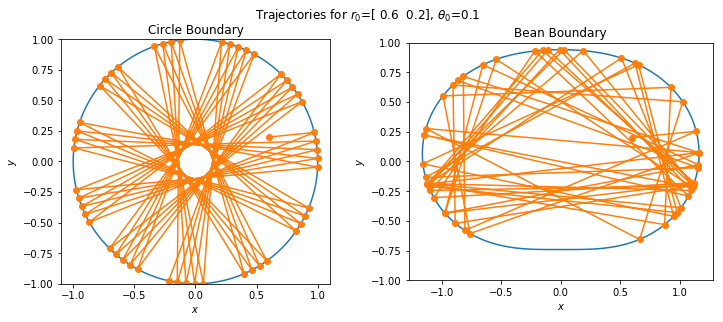

In [6]:
compare_traj_for_bdys(bdys, 50, np.array([0.6, 0.2]), 0.1)

The trajectories reflect the symmetry of the respective boundaries, with the circle boundary trajectory exhibiting a high degree of order and the bean boundary trajectory a degree of disorder but an approximate horizontal symmetry nonetheless.

The disorder in the bean boundary trajectory suggests chaos, defined as the tendency for a small change in initial conditions to produce an entirely different system trajectory. To explore this, I'll compare trajectories from a very slightly shifted initial condition, $(x_0, y_0, \theta_0) = (0.6, 0.2000001, 0.1)$.

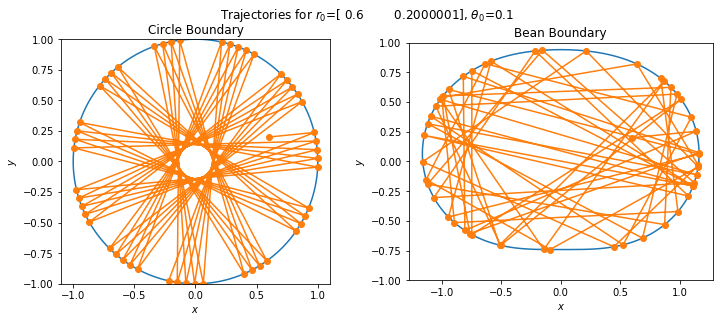

In [7]:
compare_traj_for_bdys(bdys, 50, np.array([0.6, 0.2000001]), 0.1)

As expected, the circle boundary trajectory is not visibly effected but the bean boundary trajectory has changed substantially. If these represent the true trajectories -- if they aren't significantly distorted by numerical error -- then these plots show that bean boundary billiard propagation is highly chaotic. I believe this is the case, since the primary source of numerical error in my algorithm is the rootfinding method, and I've demanded a root tolerance of $2 \cdot 10^{-12}$ --- much smaller than the change in initial conditions of $\Delta y_0 = 10^{-7}$ above. To confirm this claim, I'll examine the effects of changing initial position $y_0$ and of changing rootfinding tolerance. If the degree and manner of trajectory divergence is comparable for a difference in initial condition $\Delta y_0$ and tolerance of the same order, then the deviations in the above trajectories are due the differing initial conditions, not numerical error.

Since the bean boundary trajectories diverge much faster than the circle boundary trajectories, I'll scale $\Delta y_0$ and tolerance linearly for the circle boundary and logarithmically for the bean boundary, between $10^{-12}$ and $10^{-7}$.

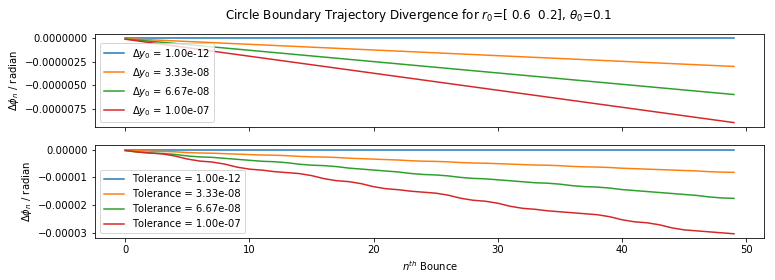

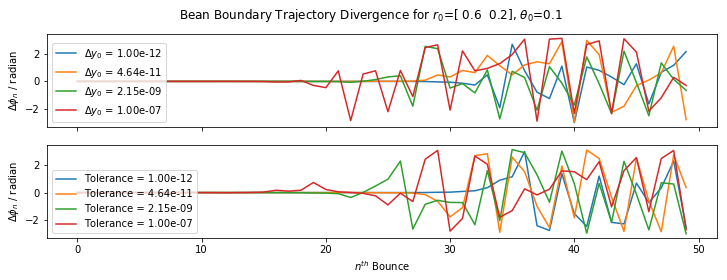

In [8]:
lines = 4
for ref_bdy, dys in ([UnitCircleBoundary(**custom_rf),
                      np.linspace(1e-12, 1e-7, num=lines)],
                     [BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf),
                      1e-12*np.logspace(0, 5, num=lines)]):
    plot_divergence(50, ref_bdy, np.array([0.6, 0.2]), 0.1, dys)

As expected, tolerance effects divergence in the same manner as initial condition perturbation, albeit at a higher magnitude of effect; a linear rate of divergence for the circle boundary, and an exponential rate for the bean boundary. Nonetheless, a $\Delta y_0$ of $10^{-7}$ causes a much faster divergence than rootfinding error with a tolerance of $2 \cdot 10^{-12}$, with the former causing the trajectory to separate at around 19 bounces and the latter at around 34, so the bean boundary trajectories exhibit true chaos. The circle boundary trajectories did not diverge appreciably for these small perturbations and low tolerances.

Trajectories (and chaos) depend strongly on initial conditions, so I'll explore another for comparison: $(x_0, y_0, \theta_0) = (0.1, 0, 1.5)$, and $(x_0, y_0, \theta_0) = (0.1, 0.0000001, 1.5)$.

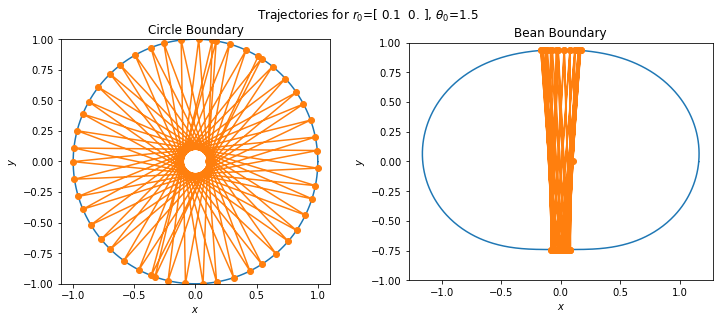

In [9]:
compare_traj_for_bdys(bdys, 50, np.array([0.1, 0]), 1.5)

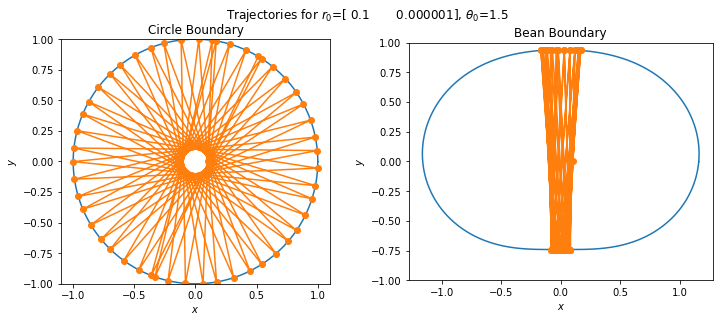

In [10]:
compare_traj_for_bdys(bdys, 50, np.array([0.1, 0.000001]), 1.5)

For this initial condition, the circle trajectory exhibits the same regularity as before but now the bean trajectory exhibits high regularity as well -- it did not appear to change when the inital position was perturbed. I'll examine the divergence.

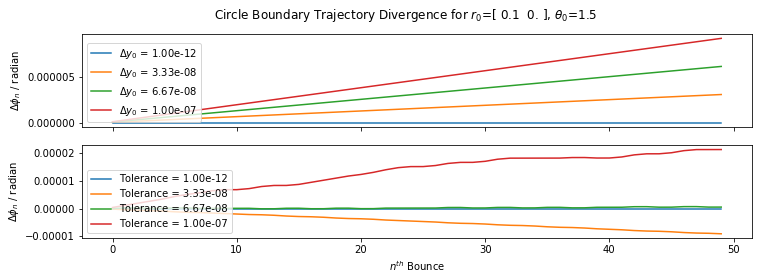

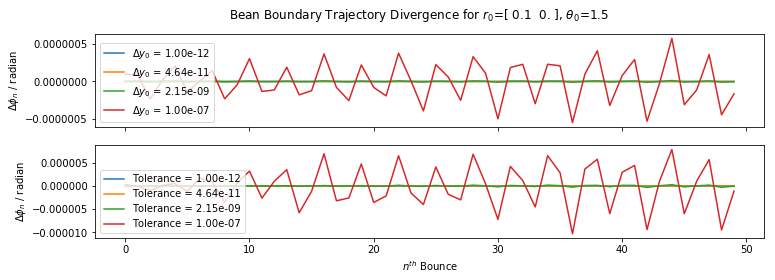

In [11]:
lines = 4
for ref_bdy, dys in ([UnitCircleBoundary(**custom_rf),
                      np.linspace(1e-12, 1e-7, num=lines)],
                     [BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf),
                      1e-12*np.logspace(0, 5, num=lines)]):
    plot_divergence(50, ref_bdy, np.array([0.1, 0]), 1.5, dys)

Indeed, perturbation and tolerance does not appreciably effect the trajectories of either the circle or the bean with these inital conditions, and in fact the bean trajectory divergence is lower than the circle trajectory divergence. It appears that perturbations here induce linear divergence in the circle boundary trajectory but oscillations in the bean boundary trajectory, so the the bean boundary trajectories diverge more slowly if at all.

# Poincaré Sections

To explore the differences in trajectories in circle boundary and bean boundary billiard propagation further, and in particular to illustrate the chaotic behaviour of the latter, I'll plot superimposed Poincaré sections for different initial conditions, side-by-side for both boundaries.

In [12]:
def compare_poinc_for_bdys(bdys, bounces, ic_list, plotargs):
    """Create side-by-side Poincare sections for the same i.c.'s
        but different boundarys.
    
    Scatters a new plot on the same axis for each (r0, v0) in ic_list.
    """
    fig, axlist = plt.subplots(1, len(bdys),
                               figsize=np.array([16,6])*figscale)
    fig.suptitle(u'Poincaré Section')
    for bdy, ax, n_per_ic in zip(bdys, axlist, bounces):
        ax.set_title(str(bdy))
        ax.set_ylabel(r'$v_{||}$')
        ax.set_xlabel(r'$\phi$ / radian')
        for [x, y, theta], n in zip(ic_list, n_per_ic):
            r0 = np.array([x, y])
            v0 = np.array([np.cos(theta), np.sin(theta)])
            plotargs['label'] = r'$r_0$ = {0},    $\theta_0$ = {1}'\
                                .format(r0, theta)
            state = reset_plots(fig, r0, v0, bdy, n,
                                poinc_ax=ax, clear_poinc_ax=False,
                                **plotargs)
    axlist[0].legend(loc='center')

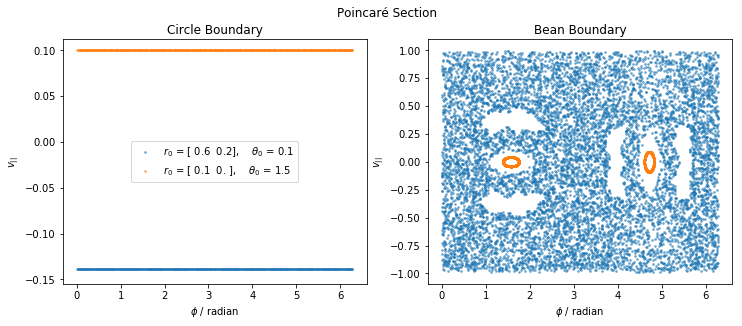

In [13]:
ic_list = [[0.6, 0.2, 0.1], [0.1, 0, 1.5]]  # x, y, theta
# num bounces per boundary per ic's
bounces = [[500, 500], [10000, 1000]]
plotargs = {'s': 3, 'alpha': 0.5}
compare_poinc_for_bdys(bdys, bounces, ic_list, plotargs)

These plots show that the circle boundary trajectories are confined to lines in the Poincaré planes while the chaotic bean boundary trajectory from $(x_0, y_0, \theta_0) = (0.6, 0.2, 0.1)$ explores nearly the entire plane --- corresponding to an incomparable difference in phase space volume. However, the non-chaotic $(x_0, y_0, \theta_0) = (0.1, 0, 1.5)$ bean boundary trajectory is one-dimensional in the Poincaré plane, like the non-chaotic circle boundary trajectories.

# Appendix
## Interactive Plotting Demo

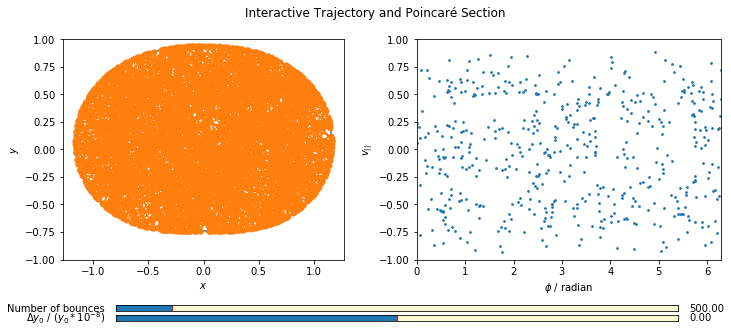

In [14]:
r0 = np.array([0.6, 0.2])
theta = 0.1
# r0 = np.array([0.1, 0])
# theta = 1.5

# bdy = UnitCircleBoundary(**custom_rf)
bdy = BeanBoundary(0.16, 0.1, 2.0, 1.0, **custom_rf)

bounces = 500
rdy_func = lambda r, dy: r * np.array([1, 1 + dy*1e-8])
deltay = 0
max_bounces = 5000
max_deltay = 50
plotargs = {'s': 3}

fig, axlist = plt.subplots(1, 2, figsize=np.array([16,6])*figscale)
fig.suptitle(u'Interactive Trajectory and Poincaré Section')
bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
axlist[0].plot(bdyline[0], bdyline[1])
# Plot empty trajectory line object; I'll send data to it after 
traj_line, = axlist[0].plot([0, 0], [0, 0], 'o-', markersize=5)
axlist[0].set_aspect('equal')
axlist[0].set_ylim([-1, 1])
axlist[0].set_xlabel(r'$x$')
axlist[0].set_ylabel(r'$y$')
poinc_ax = axlist[1]
poinc_ax.set_ylabel(r'$v_{||}$')
poinc_ax.set_xlabel(r'$\phi$ / radian')

v0 = np.array([np.cos(theta), np.sin(theta)])
# Initialize plotline data
state = reset_plots(fig, rdy_func(r0, deltay), v0, bdy,
                    bounces, traj_line, poinc_ax, **plotargs)

sbounces, sdeltay = make_interactive(fig, state, r0, v0, bdy,
                                     bounces, max_bounces,
                                     deltay, max_deltay, rdy_func,
                                     traj_line, poinc_ax, **plotargs)

## Boundary Classes

In [ ]:
# %load boundary.py
"""Classes of 1D convex boundaries providing methods for billiard sims."""
from __future__ import division
import abc
import numpy as np
import scipy.optimize as opt

class BilliardBoundary_abstract(object):
    """Define 1D convex boundary methods required for billiard sims."""
    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def coords_cart(self, s):
        """Get the cartesian coordinates at parameter value s.
        return np.array([x, y])"""
        raise NotImplementedError('')

    @abc.abstractmethod
    def tangent_cart(self, s):
        """Get the cartesian tangent vector at parameter value s.
        return np.array([x, y])"""
        raise NotImplementedError('')

    @abc.abstractmethod
    def linear_intersect_cart(self, x0, v):
        """Get (the parameter value) at the intersection with given line.
        This variant expects cartesian start x0."""
        raise NotImplementedError('')

    @abc.abstractmethod
    def linear_intersect_param(self, s0, v):
        """Get (the parameter value) at the intersection with given line.
        This variant expects parametric start s0."""
        raise NotImplementedError('')

    def _linear_intersect_function(self, x0, v):
        """Return function whose root gives bdy intersect with given line."""
        return lambda s: np.dot(self.coords_cart(s) - x0,
                                np.array([v[1], -v[0]]))

    def _linear_inter_func_derivative(self, v):
        return lambda s: np.dot(self.tangent_cart(s), np.array([v[1], -v[0]]))


class ContinuousDifferentiableBoundary_abstract(BilliardBoundary_abstract):
    """Billiard methods for 1D continuous differentiable convex boundaries."""
    __metaclass__ = abc.ABCMeta

    def __init__(self, domain, tol=2E-12, maxiter=50,
                 rootfind_open=opt.newton, rootfind_bracketing=opt.brentq,
                 param_rootfind='bracketing'):
        # domain is the period of the parameter (assumed cyclic, 0 origin)
        self.domain = domain
        self.tol = tol
        self.maxiter = maxiter
        self.rf_open = rootfind_open
        self.rf_bracketing = rootfind_bracketing
        self.param_rootfind = param_rootfind           

    @abc.abstractmethod
    def _linear_inter_func_d2(self, v):
        """Second derivative of linear intersection function, for second-order
            rootfinding methods.
        """
        raise NotImplementedError('')

    def linear_intersect_cart(self, x0, v, s0=0):
        """Find a linear intersection from arbitrary cartesian x0.
        
        Default: opt.newton. If fprime2 is not none, uses Halley's parabolic
         root finder; otherwise, the Newton-Raphson method.
        Scipy's implementation does not provide return convergence info,
         unlike mine. For compatibility I'll leave full_output disabled.
        If s0 is given (presumably x0 is on the boundary) I start the search
         at the angle opposite, to help avoid finding the previous intersect.
        """
        s = self.rf_open(self._linear_intersect_function(x0, v),
                         s0 + self.domain/2,
                         fprime=self._linear_inter_func_derivative(v),
                         fprime2=self._linear_inter_func_d2(v),
                         tol=self.tol, maxiter=self.maxiter)
        return s % self.domain

    def linear_intersect_param(self, s0, v):
        """Find a linear intersection from a point s0 on boundary."""
        if self.param_rootfind == 'bracketing':
            return self._linear_intersect_param_bracketing(s0, v)
        elif self.param_rootfind == 'open':
            return self._linear_intersect_param_open(s0, v)
        else: raise RuntimeError('')
 
    def _linear_intersect_param_open(self, s0, v):
        """Open methods do not require an interval, and can be faster.

        With an open search domain, it is possible to find the wrong root...
        Default: opt.newton.
        """
        return self.linear_intersect_cart(self.coords_cart(s0), v, s0=s0) 

    def _linear_intersect_param_bracketing(self, s0, v):
        """Bracketing methods search within an interval, so I can exclude s0.

        Default: opt.brentq, Brent's method with quadratic interpolation.
        """
        x0 = self.coords_cart(s0)
        s, info = self.rf_bracketing(self._linear_intersect_function(x0, v),
                                     s0 + 1e-8*self.domain,
                                     s0 + (1 - 1e-8)*self.domain,
                                     xtol=self.tol, maxiter=self.maxiter,
                                     full_output=True, disp=False)
        if info.converged:
            return s % self.domain
        else:
            raise RuntimeError(repr(info))


class UnitCircleBoundary(ContinuousDifferentiableBoundary_abstract):
    """Circular boundary of unit radius parameterized by angle."""

    def __init__(self, **kwargs):
        super(UnitCircleBoundary, self).__init__(2*np.pi, **kwargs)

    def __str__(self):
        return 'Circle Boundary'

    def coords_cart(self, s):
        return np.array([np.cos(s), np.sin(s)])

    def tangent_cart(self, s):
        return np.array([-np.sin(s), np.cos(s)])  # already normalized

    def _linear_inter_func_d2(self, v):
        return lambda s:np.dot(-self.coords_cart(s), np.array([v[1], -v[0]]))


class BeanBoundary(ContinuousDifferentiableBoundary_abstract):
    """Shape defined by r(s) = 1 + a*cos(c*s) + b*sin(d*s)

    I have lots of instance variables, so I'll type 'o' for 'self'.
    """

    def __init__(o, a, b, c, d, **kwargs):
        super(BeanBoundary, o).__init__(2*np.pi, **kwargs)
        o.a = a
        o.b = b
        o.c = c
        o.d = d

    def __str__(o):
        return 'Bean Boundary'

    def coord_polar(o, s):
        return 1 + o.a * np.cos(o.c * s) + o.b * np.sin(o.d * s)

    def coords_cart(o, s):
        return o.coord_polar(s) * np.array([np.cos(s), np.sin(s)])

    def derivative_polar(o, s):
        return -o.a*o.c * np.sin(o.c * s) + o.b*o.d * np.cos(o.d * s)

    def tangent_cart(o, s):
        tan = (o.derivative_polar(s) * np.array([np.cos(s), np.sin(s)])
               + o.coord_polar(s) * np.array([-np.sin(s), np.cos(s)]))
        return tan / np.linalg.norm(tan)

    def _linear_inter_func_d2(o, v):
        """Not worthwhile to use higher order solver for this boundary."""
        return None


## Rootfinding Methods

In [ ]:
# %load rootfinding/scalar_methods.py
import numpy as np
from scipy.optimize.zeros import RootResults
# RootResults is a class for representing the results and convergence of
#  rootfinding methods. I'll use it for compatibility with scipy.optimize.

def bisect(f, a, b, xtol=1e-12, maxiter=50, full_output=False, disp=True):
    assert f(a) * f(b) < 0
    flag = 0
    est_err = 1
    for iteration in range(maxiter):
        mid = (a + b) / 2
        if f(mid)*f(a) < 0:
            b = mid
        elif f(mid)*f(b) < 0:
            a = mid
        est_err = abs(a - b) / mid
        if est_err <= xtol:
            break
    else:  # executed if loop didn't break
        flag = -2  # CONVERR
        if disp: raise RuntimeError('Failed to converge to tolerance {0}\
                                     after {1} iterations. Found {2} with\
                                     estimated error {3}.'
                                     .format(tol, maxiter, x, est_err))       
    if full_output:
        r = RootResults(root=mid,
                        iterations=iteration+1,
                        function_calls=2*(iteration+1 + 1),
                        flag=flag)
        return [mid, r]
    return mid


def newton(f, a0, a1=None, fprime=None, fprime2=None,
           maxiter=50, tol=1e-8, full_output=False, disp=True):
    flag = 0
    if fprime is None:
        # use secant method
        def secant_iter_gen(xprev, x, f):
            f_calls = 0
            est_err = 1
            while True:
                yield x, xprev, est_err, f_calls
                xnext = x - f(x) * (x - xprev) / (f(x) - f(xprev))
                xprev = x; x = xnext;
                est_err = abs((x - xprev) / x)
                f_calls += 3
        if a1 is None:  # make one up. Using the method from scipy.optimize:
            delta = 1e-4 if a0 >= 0 else -1e-4
            a1 = a0 * (1 + delta) + delta
        method = secant_iter_gen(a0, a1, f)
    else:
        # use Newton-Raphson method
        def NR_iter_gen(x, f, fprime):
            f_calls = 0
            est_err = 1
            xprev = x
            while True:
                yield x, xprev, est_err, f_calls
                xprev = x
                x = xprev - f(xprev) / fprime(xprev)
                est_err = abs((x - xprev) / x)
                f_calls += 2
        method = NR_iter_gen(a0, f, fprime)
    # TODO: if fprime2 is not None, use Halley's method.

    x, xprev, est_err, f_calls = method.next()
    for iteration in range(maxiter):
        x, xprev, est_err, f_calls = method.next()
        if est_err <= tol:
            break
    else:  # executed if loop didn't break
        flag = -2  # CONVERR
        if disp: raise RuntimeError('Failed to converge to tolerance {0}\
                                     after {1} iterations. Found {2} with\
                                     estimated error {3}.'
                                     .format(tol, maxiter, x, est_err))
    if full_output:
        r = RootResults(root=x,
                        iterations=iteration+1,
                        function_calls=f_calls,
                        flag=flag)
        return [x, r]
    return x
